#  Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

**id** - a unique identifier for each trip 

**vendor_id** - a code indicating the provider associated with the trip record

**pickup_datetime** - date and time when the meter was engaged

**dropoff_datetime** - date and time when the meter was disengaged

**passenger_count** - the number of passengers in the vehicle (driver entered value)

**pickup_longitude** - the longitude where the meter was engaged

**pickup_latitude** - the latitude where the meter was engaged

**dropoff_longitude** - the longitude where the meter was disengaged

**dropoff_latitude** - the latitude where the meter was disengaged

**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)

**trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from xgboost import XGBRegressor
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Load Data File

In [2]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

### File structure and content

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [5]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
for i in['pickup','dropoff']:
    df['{}_datetime'.format(i)] = pd.to_datetime(df['{}_datetime'.format(i)])
    df['{}_month'.format(i)] = df['{}_datetime'.format(i)].apply(lambda x:x.month)
    df['{}_hour'.format(i)] = df['{}_datetime'.format(i)].apply(lambda x:x.hour)

In [7]:
df['pickup_day_name'] = df['pickup_datetime'].dt.weekday

In [8]:
df.select_dtypes(include=['int64','float64','Int64']).dtypes

vendor_id              int64
passenger_count        int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_duration          int64
pickup_month           int64
pickup_hour            int64
dropoff_month          int64
dropoff_hour           int64
pickup_day_name        int64
dtype: object

In [9]:
numerical = ["pickup_hour" , "dropoff_hour"]


categorical = ["passenger_count","pickup_month","dropoff_month","pickup_day_name","dropoff_day_name"]


cat_geofence = ["pickup_longitude", "pickup_latitude" , "dropoff_longitude",
                            
                "dropoff_latitude"]

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,729322.0,1.535403,0.498745,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,729322.0,1.662055,1.312446,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,729322.0,-73.973513,0.069754,-121.933342,-73.991859,-73.981758,-73.967361,-6.589738e+01
pickup_latitude,729322.0,40.750919,0.033594,34.712234,40.737335,40.754070,40.768314,5.188108e+01
dropoff_longitude,729322.0,-73.973422,0.069588,-121.933304,-73.991318,-73.979759,-73.963036,-6.589738e+01
dropoff_latitude,729322.0,40.751775,0.036037,32.181141,40.735931,40.754509,40.769741,4.392103e+01
trip_duration,729322.0,952.229133,3864.626197,1.000000,397.000000,663.000000,1075.000000,1.939736e+06
pickup_month,729322.0,3.518410,1.680661,1.000000,2.000000,4.000000,5.000000,6.000000e+00
pickup_hour,729322.0,13.611698,6.402853,0.000000,9.000000,14.000000,19.000000,2.300000e+01
dropoff_month,729322.0,3.518764,1.680815,1.000000,2.000000,4.000000,5.000000,7.000000e+00


In [14]:
# Remove passenger_count outliers
df = df[df['passenger_count']>0]
df = df[df['passenger_count']<9]

# df = df[df['pickup_longitude'] <= -73.968285]
# df = df[df['pickup_longitude'] >= -74.0059]
# df = df[df['pickup_latitude'] <= 40.748817]
# df = df[df['pickup_latitude'] >= 40.7128]
# df = df[df['dropoff_longitude'] <= -73.968285]
# df = df[df['dropoff_longitude'] >= -74.0059]
# df = df[df['dropoff_latitude'] <= 40.748817]
# df = df[df['dropoff_latitude'] >= 40.7128]

# Remove coordinate outliers
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

# Remove trip_duration outliers
trip_duration_mean = np.mean(df['trip_duration'])
trip_duration_std = np.std(df['trip_duration'])
df = df[df['trip_duration']<=trip_duration_mean + 2*trip_duration_std]
df = df[df['trip_duration']>= trip_duration_mean - 2*trip_duration_std]

# Confirm removal
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,718612.0,1.534781,0.498789,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,718612.0,1.661748,1.312429,1.000000,1.000000,1.000000,2.000000,6.000000
pickup_longitude,718612.0,-73.973820,0.037160,-74.029953,-73.991867,-73.981781,-73.967537,-73.750664
pickup_latitude,718612.0,40.751021,0.027423,40.630432,40.737468,40.754089,40.768280,40.849991
dropoff_longitude,718612.0,-73.973551,0.032633,-74.029999,-73.991280,-73.979858,-73.963516,-73.750122
dropoff_latitude,718612.0,40.751647,0.029660,40.630001,40.736309,40.754501,40.769478,40.849998
trip_duration,718612.0,824.090626,641.347706,1.000000,394.000000,655.000000,1056.000000,8588.000000
pickup_month,718612.0,3.517464,1.680758,1.000000,2.000000,4.000000,5.000000,6.000000
pickup_hour,718612.0,13.621609,6.382446,0.000000,9.000000,14.000000,19.000000,23.000000
dropoff_month,718612.0,3.517744,1.680893,1.000000,2.000000,4.000000,5.000000,7.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718612 entries, 0 to 729321
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  718612 non-null  object        
 1   vendor_id           718612 non-null  int64         
 2   pickup_datetime     718612 non-null  datetime64[ns]
 3   dropoff_datetime    718612 non-null  datetime64[ns]
 4   passenger_count     718612 non-null  int64         
 5   pickup_longitude    718612 non-null  float64       
 6   pickup_latitude     718612 non-null  float64       
 7   dropoff_longitude   718612 non-null  float64       
 8   dropoff_latitude    718612 non-null  float64       
 9   store_and_fwd_flag  718612 non-null  object        
 10  trip_duration       718612 non-null  int64         
 11  pickup_month        718612 non-null  int64         
 12  pickup_hour         718612 non-null  int64         
 13  dropoff_month       718612 no

In [16]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime) # Pickups
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime) # Drop-offs

# Confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718612 entries, 0 to 729321
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  718612 non-null  object        
 1   vendor_id           718612 non-null  int64         
 2   pickup_datetime     718612 non-null  datetime64[ns]
 3   dropoff_datetime    718612 non-null  datetime64[ns]
 4   passenger_count     718612 non-null  int64         
 5   pickup_longitude    718612 non-null  float64       
 6   pickup_latitude     718612 non-null  float64       
 7   dropoff_longitude   718612 non-null  float64       
 8   dropoff_latitude    718612 non-null  float64       
 9   store_and_fwd_flag  718612 non-null  object        
 10  trip_duration       718612 non-null  int64         
 11  pickup_month        718612 non-null  int64         
 12  pickup_hour         718612 non-null  int64         
 13  dropoff_month       718612 no

In [17]:
df['pickup_date'] = df['pickup_datetime'].dt.date # Extract date
df['pickup_time'] = df['pickup_datetime'].dt.time # Extract time

# Delimit dropoff_datetime variables
df['dropoff_date'] = df['dropoff_datetime'].dt.date # Extract date
df['dropoff_time'] = df['dropoff_datetime'].dt.time # Extract time

# Additional pickup features
df['pickup_month'] = df['pickup_datetime'].dt.month # Extract month
# df['pickup_month'] = df.pickup_datetime.dt.to_period('M') # Extract yearmonth
#df['pickup_YYYYMM'] = df['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
df['pickup_hour'] = df['pickup_datetime'].dt.hour # Extract hour
df['pickup_weekday'] = df['pickup_datetime'].dt.dayofweek # Extract day of week

# Drop concatentated timestamp columns
df.drop(['pickup_datetime'], axis = 1, inplace = True)
df.drop(['dropoff_datetime'], axis = 1, inplace = True)

# Confirm changes
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_month', 'pickup_hour',
       'dropoff_month', 'dropoff_hour', 'pickup_day_name', 'pickup_date',
       'pickup_time', 'dropoff_date', 'dropoff_time', 'pickup_weekday'],
      dtype='object')

In [18]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N':0,'Y':1})

In [19]:
X = df[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']] # double brackets!

# Create array of target variable 
y = df['trip_duration']

# Create train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [20]:
#  Instantiate model object
lreg = LinearRegression()

# Fit to training data
lreg.fit(X_train,y_train)
print(lreg)

# Predict
y_pred_lreg = lreg.predict(X_test)

# Score It

print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_lreg))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_lreg))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_lreg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_lreg)))

LinearRegression()

Linear Regression Performance Metrics
R^2= 0.2279472211116701
MAE: 405.4400437707393
MSE: 317735.50447282114
RMSE: 563.6803211686755


In [21]:
# Instantiate model object
dtree = DecisionTreeRegressor()

# Fit to training data
dtree.fit(X_train,y_train)
print(dtree)

# Predict
y_pred_dtree = dtree.predict(X_test)

# Score It

print('\nDecision Tree Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_test,y_pred_dtree))
print('MAE:',metrics.mean_absolute_error(y_test,y_pred_dtree))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_dtree))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred_dtree)))

DecisionTreeRegressor()

Decision Tree Regression Performance Metrics
R^2= 0.5674563554831253
MAE: 265.4128601546029
MSE: 178102.18283955942
RMSE: 422.02154309887953


In [22]:
# Instantiate model object
rforest = RandomForestRegressor(n_estimators = 20, n_jobs = -1)

# Fit to training data
rforest = rforest.fit(X_train,y_train)
print(rforest)

# Predict
y_pred_rforest = rforest.predict(X_test)

# Score It

print('\nRandom Forest Regression Performance Metrics')
print('R^2 =',metrics.explained_variance_score(y_test,y_pred_rforest))
print('MAE',metrics.mean_absolute_error(y_test, y_pred_rforest))
print('MSE',metrics.mean_squared_error(y_test, y_pred_rforest))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test, y_pred_rforest)))

RandomForestRegressor(n_estimators=20, n_jobs=-1)

Random Forest Regression Performance Metrics
R^2 = 0.7815972392627919
MAE 190.62632320505418
MSE 89964.8173900048
RMSE 299.94135658492445


In [23]:
start_time = time.time()
lm_regression = LinearRegression()
lm_regression = lm_regression.fit(X_train, y_train)
end_time = time.time()
lm_time = (end_time - start_time)
print(f"Time taken to train linear regression model : {lm_time} seconds")

Time taken to train linear regression model : 0.0980215072631836 seconds


In [24]:
trips = lm_regression.predict(X_test)
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips.flatten()})
predictions

,Actual,Predicted
666156,620,889.996096
200165,526,828.436485
723808,4010,1877.320500
397253,786,824.806659
213378,459,664.728059
...,...,...
609558,240,670.287195
509329,1659,560.334670
281817,474,690.953917
34580,1672,703.392338


In [25]:
lm_score = r2_score(y_test, trips)
print(lm_score)

0.22794539249266133


In [26]:
start_time = time.time()
dt_regression = DecisionTreeRegressor()
dt_regression = dt_regression.fit(X_train, y_train)
end_time = time.time()
dt_time = (end_time - start_time)
print(f"Time taken to train Decision tree model : {dt_time} seconds")

Time taken to train Decision tree model : 6.84454607963562 seconds


In [27]:
trips = dt_regression.predict(X_test)
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips.flatten()})
predictions

,Actual,Predicted
666156,620,640.0
200165,526,358.0
723808,4010,3350.0
397253,786,1037.0
213378,459,589.0
...,...,...
609558,240,244.0
509329,1659,2034.0
281817,474,930.0
34580,1672,1210.0


In [28]:
dt_score = r2_score(y_test, trips)
print(dt_score)

0.5667208979966489


In [29]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.01      0.05      0.02        20
           3       0.02      0.09      0.04        33
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00        20
           9       0.01      0.05      0.02        20
          10       0.00      0.00      0.00        17
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00        10
          13       0.01      0.09      0.03        11
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00         9
          18       0.00    

### Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

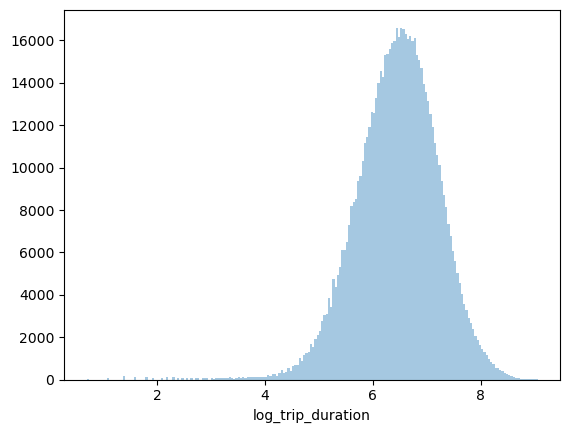

In [32]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

We find:

 1- The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5) i.e. about 17 minutes.
 
 2- There are several suspiciously short rides with less than 10 seconds duration.
 
 3- As discussed earlier, there are a few huge outliers near 12.

### Numerical_Univariate

In [33]:
def UVA_numeric(df, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = df[i].min()
    maxi = df[i].max()
    ran = df[i].max()-df[i].min()
    mean = df[i].mean()
    median = df[i].median()
    st_dev = df[i].std()
    skew = df[i].skew()
    kurt = df[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(df[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))


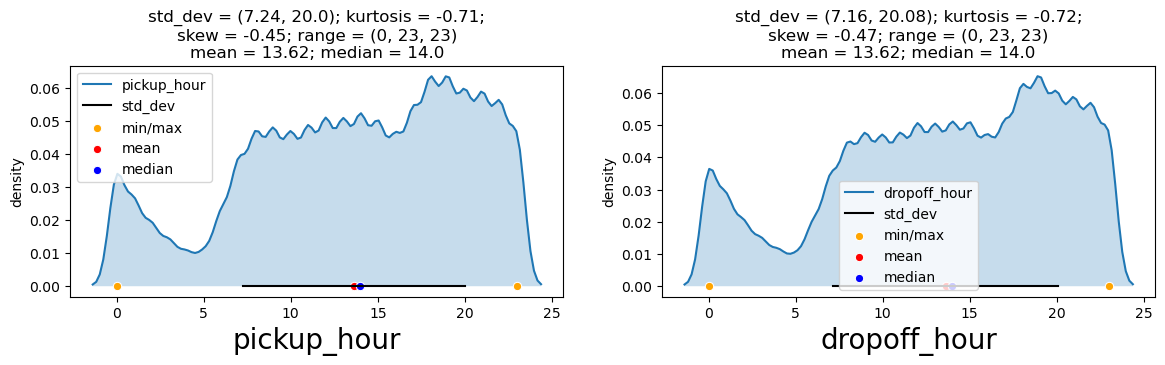

In [34]:
UVA_numeric(df , numerical)

Text(0, 0.5, 'Frequency')

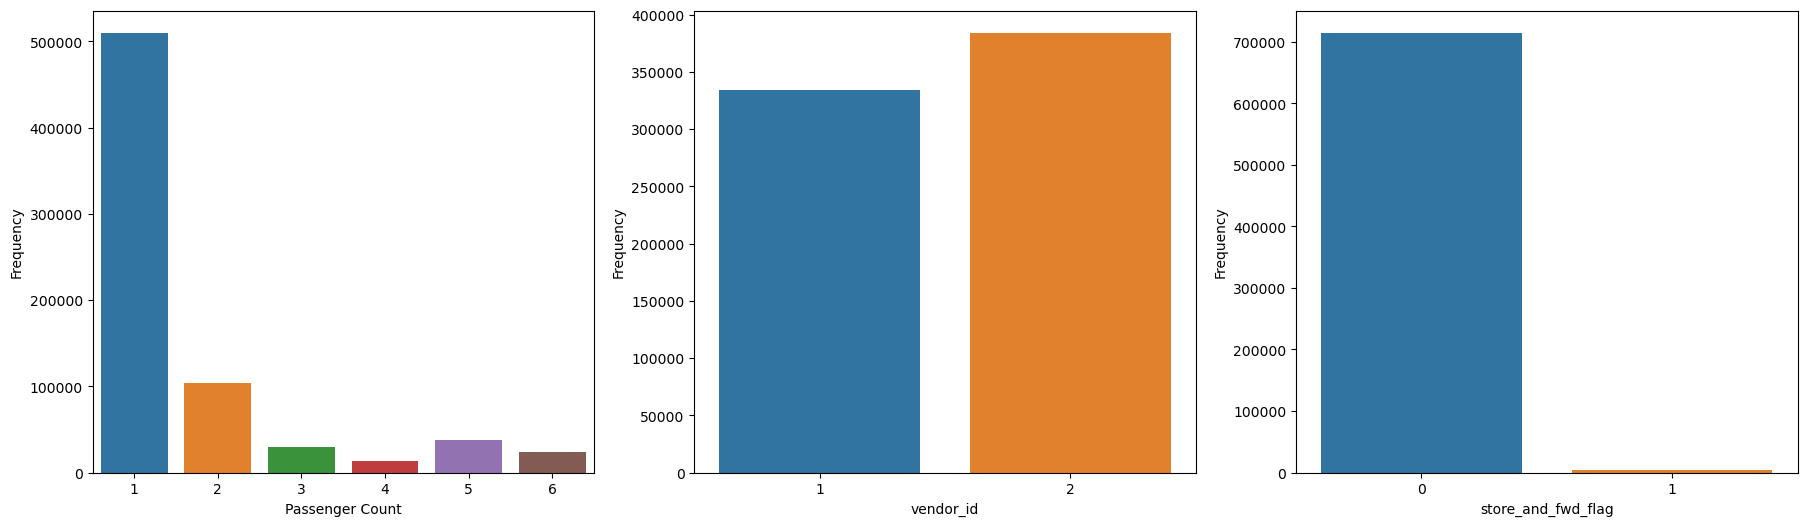

In [35]:
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')

Observations:

Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
Vendor 2 has more number of trips as compared to vendor 1
The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

Text(0, 0.5, 'Total number of pickups')

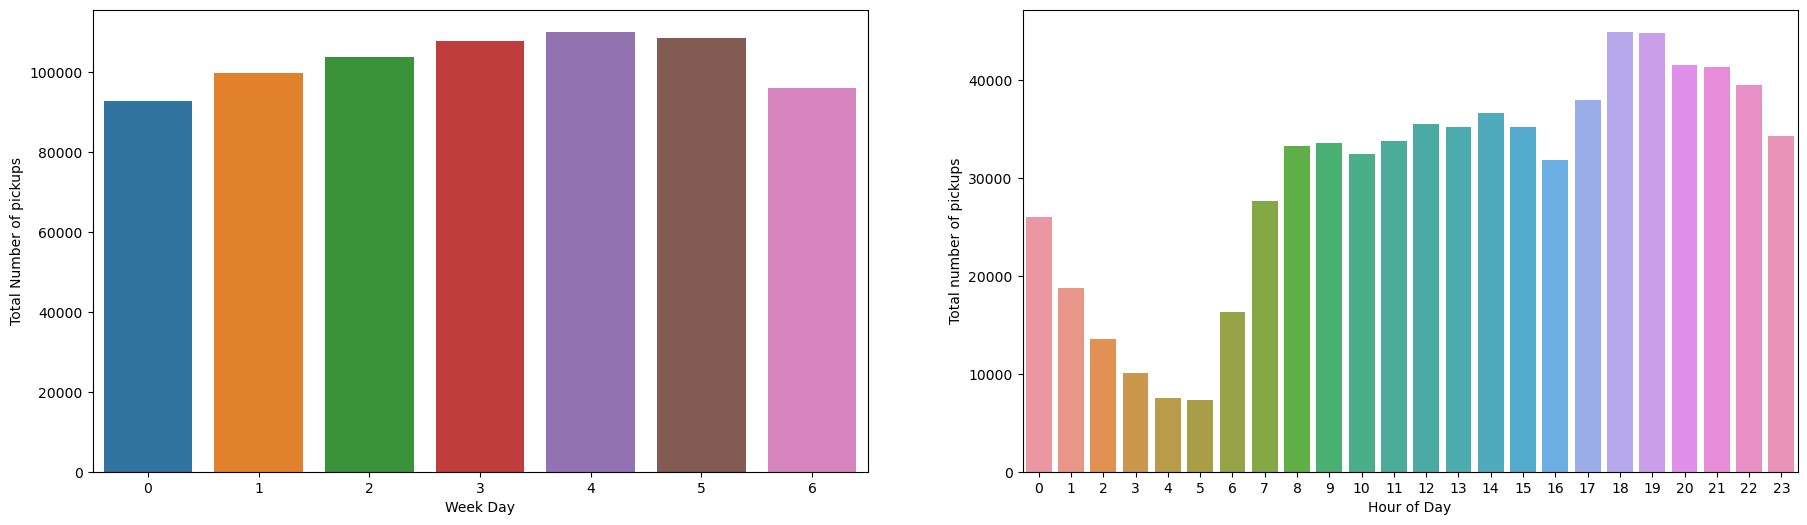

In [36]:
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['pickup_day_name'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['pickup_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')

* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.

* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

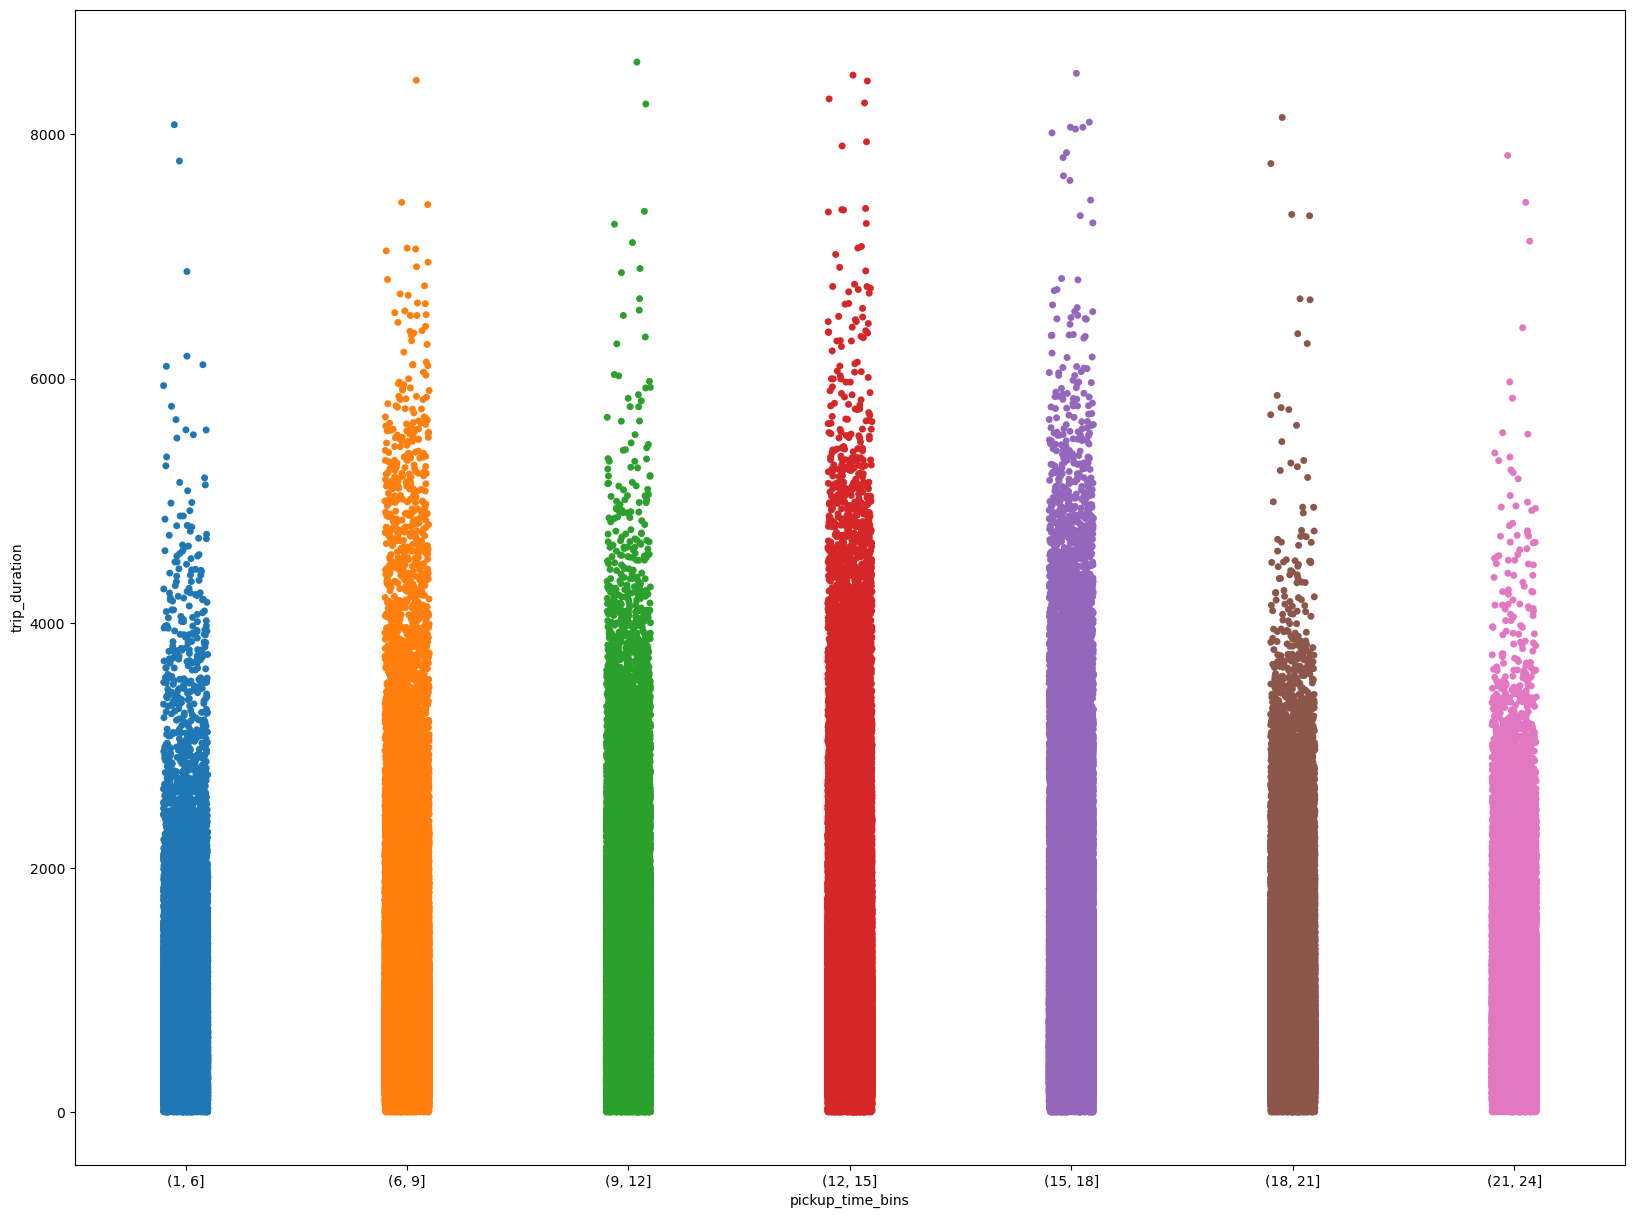

In [37]:
df['pickup_time_bins'] = pd.cut(x = df['pickup_hour'], bins=[1,6,9,12,15,18,21,24])
df['pickup_time_bins'].value_counts(normalize = True)

plt.figure(figsize = (20,15))
sns.stripplot(x="pickup_time_bins", y="trip_duration",data=df)
plt.show()

* Distribution across all pickup_time_bins is similar,crowded at extremes at either less or more trip_duration. Less trip_duration being more popular among users.

* tip_duration across all time bins is either very high or less than 3hrs, this suggest there are ride products made for booking cabs for more than a day or so.

* During daytime viz.1200hrs to 1500hrs and 1500hrs to 1800hrs trip_duration has greater distribution.

* Most rides are taken for less than 10000 sec ~ within 3hrs.

## Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

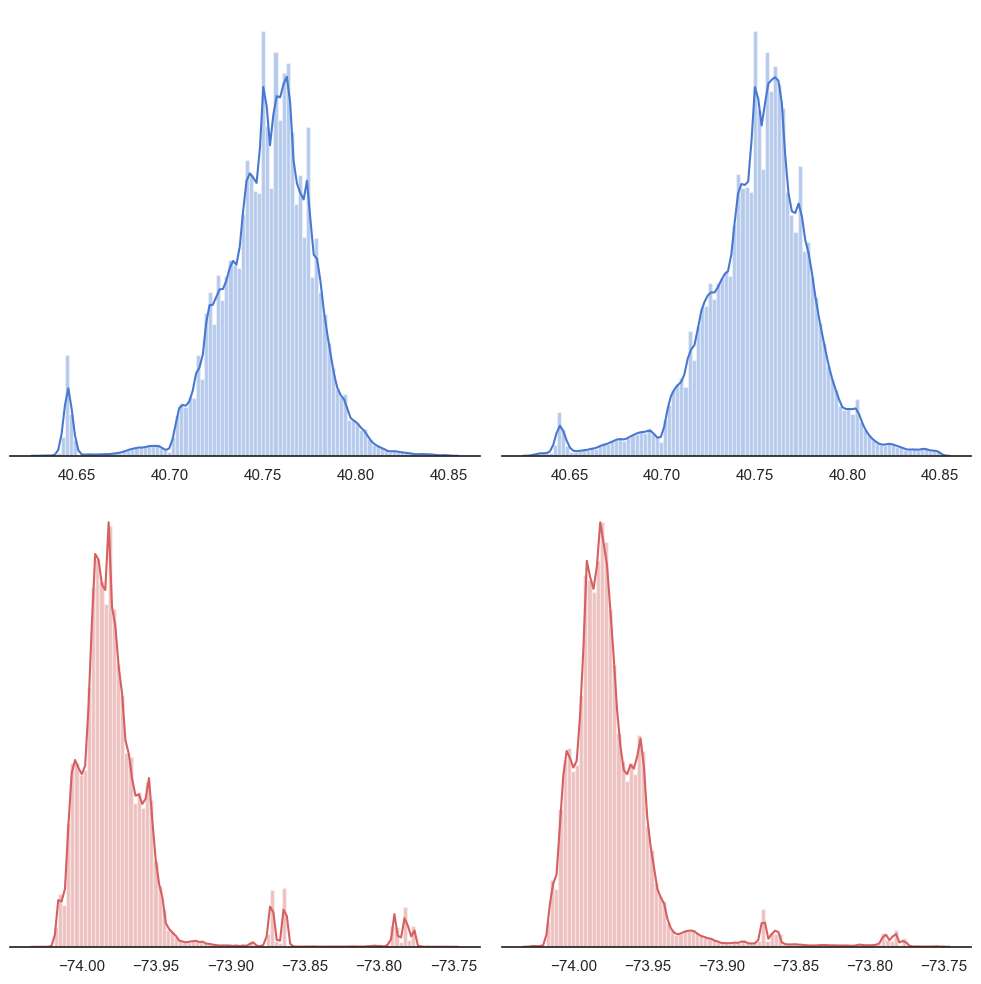

In [38]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

* From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73.
* Some extreme co-ordinates has squeezed the plot such that we see a spike here
* A good idea is to remove these outliers and look at the distribution more closely

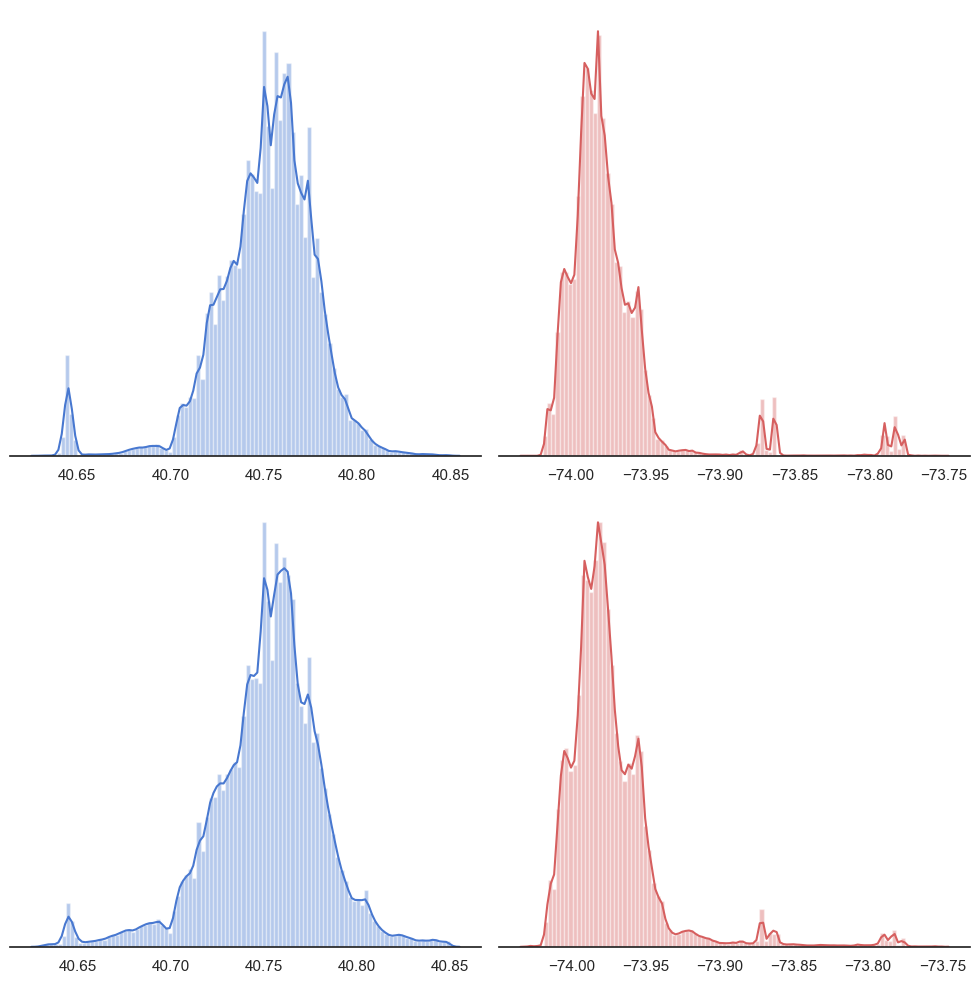

In [39]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms

### Bivariate Relations with Target

### Trip Duration vs Weekday
For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

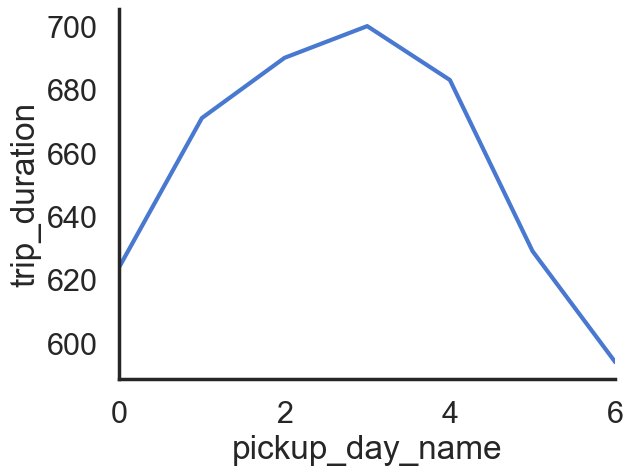

In [40]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['pickup_day_name'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="pickup_day_name", unit = "unit", value="trip_duration")
sns.despine(bottom = False)

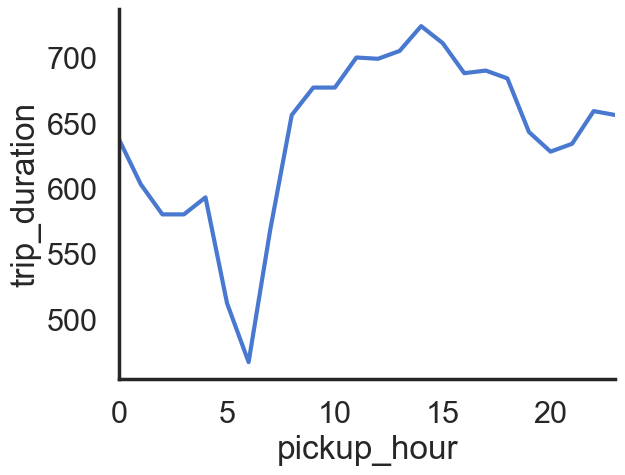

In [41]:
summary_hourly_avg_duration = pd.DataFrame(df.groupby(['pickup_hour'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_hourly_avg_duration, time="pickup_hour", unit = "unit", value="trip_duration")
sns.despine(bottom = False)



* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

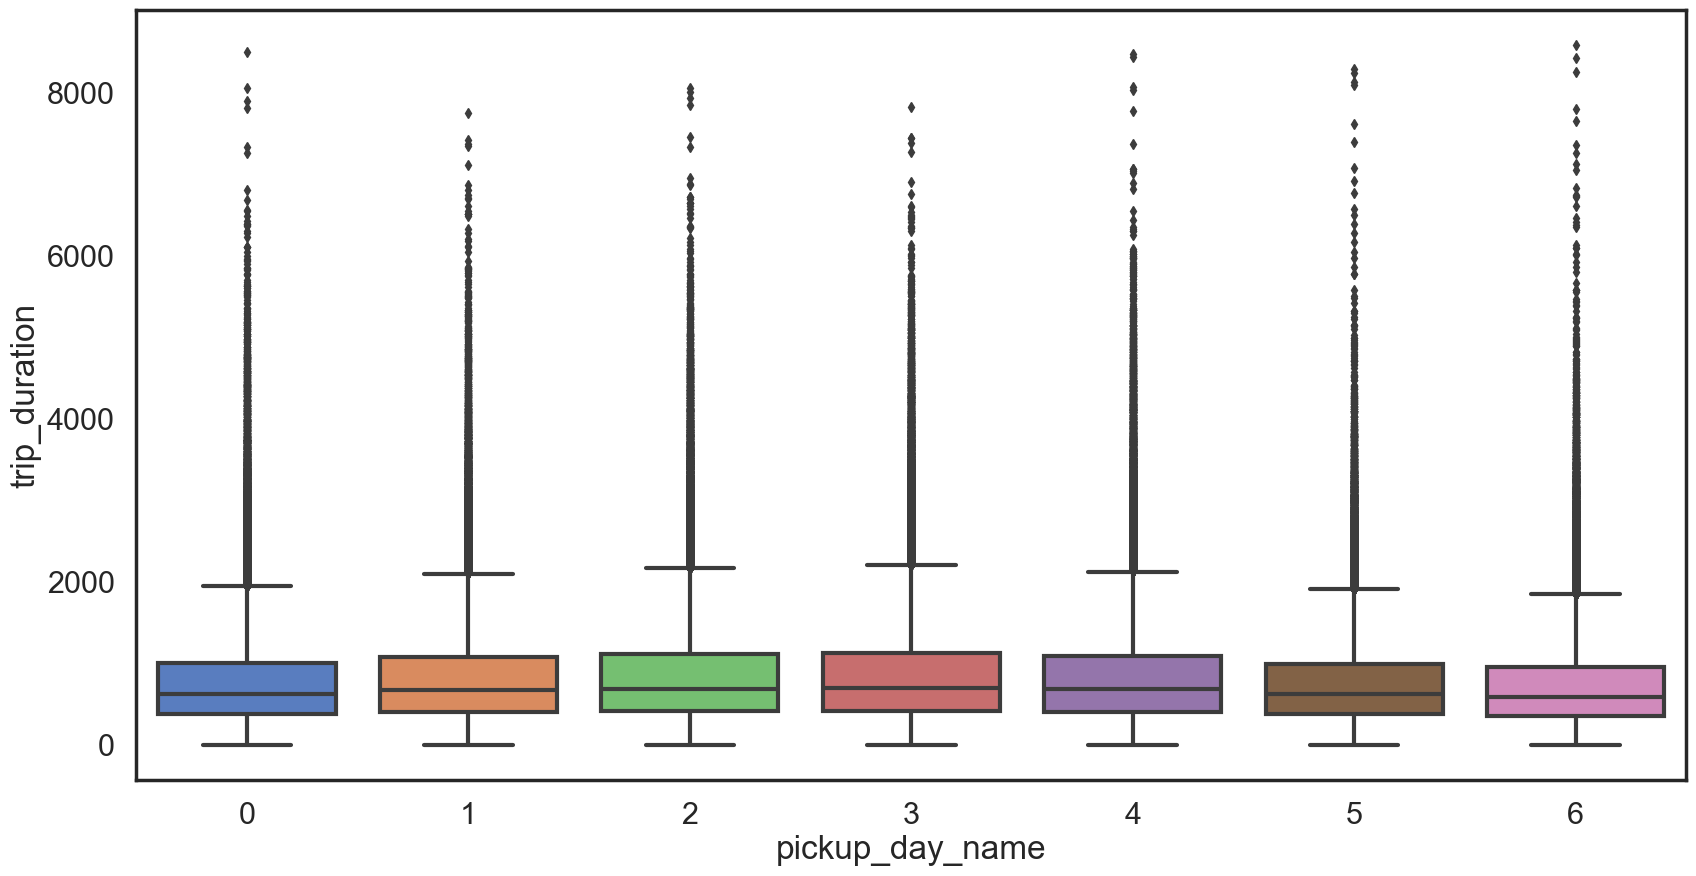

In [42]:
plt.figure(figsize = (20,10))
sns.boxplot(x="pickup_day_name", y="trip_duration",data=df)
plt.show()

1- Average trip_duration is higher on Thursday and Friday than other days.

2- We see error bars at top of each bar which on plotting boxplot reveals Tueday's trip has extreme outliers.

3- Boxplot also reveals that most trip_durations among the data are concentrated below 10000 seconds or less than 3 hours.

### Trip Duration vs Passenger Count
Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [43]:
df.passenger_count.value_counts()

1    510065
2    103375
5     38337
3     29232
6     23772
4     13831
Name: passenger_count, dtype: int64

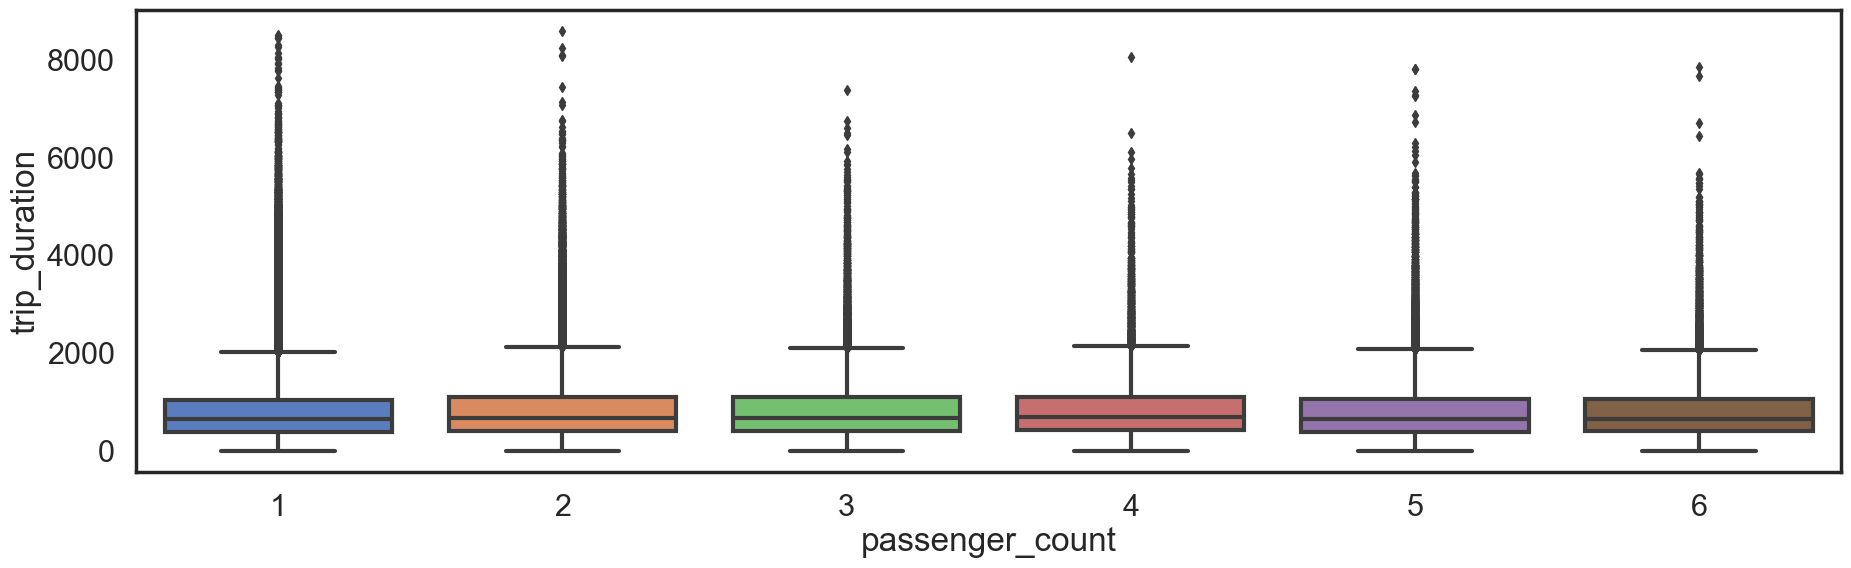

In [44]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map
Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

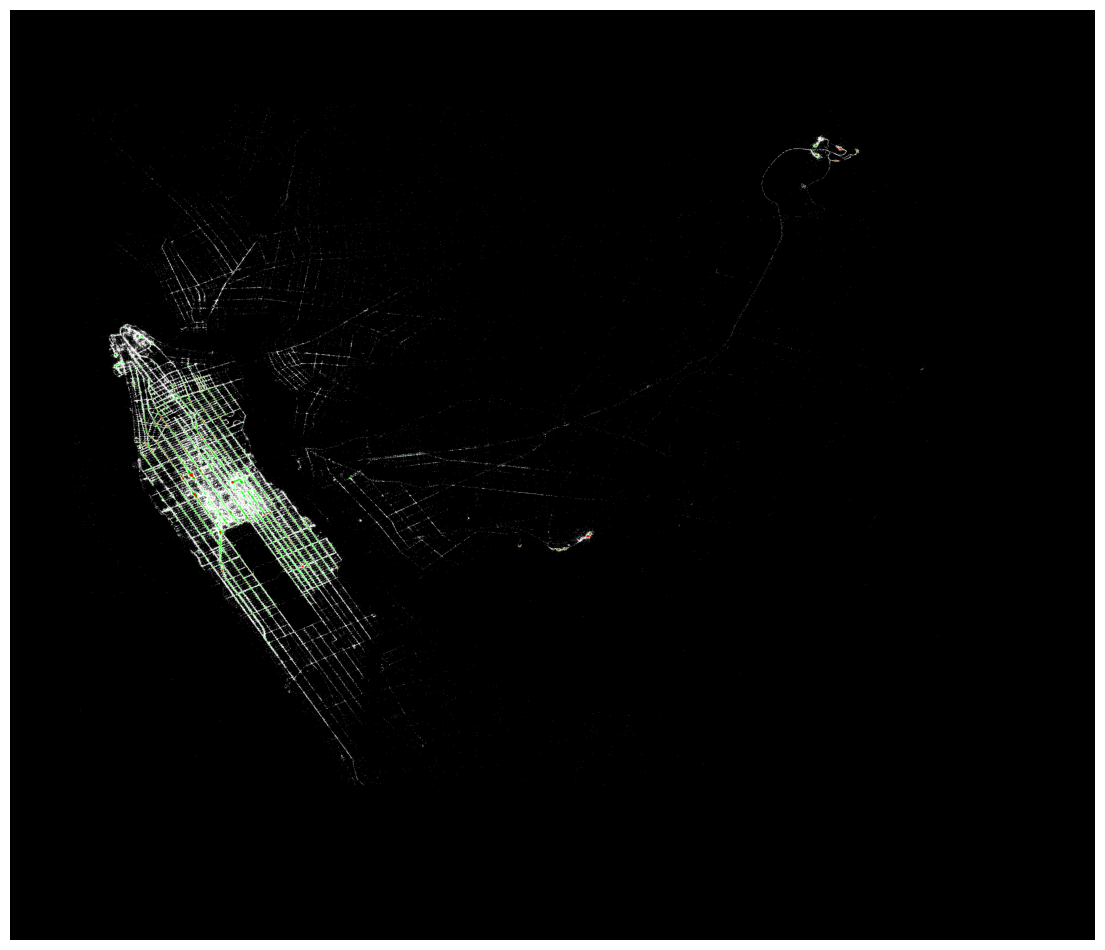

In [45]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

### Correlation Heatmap
Let us quickly look at the correlation heatmap to check the correlations amongst all features.

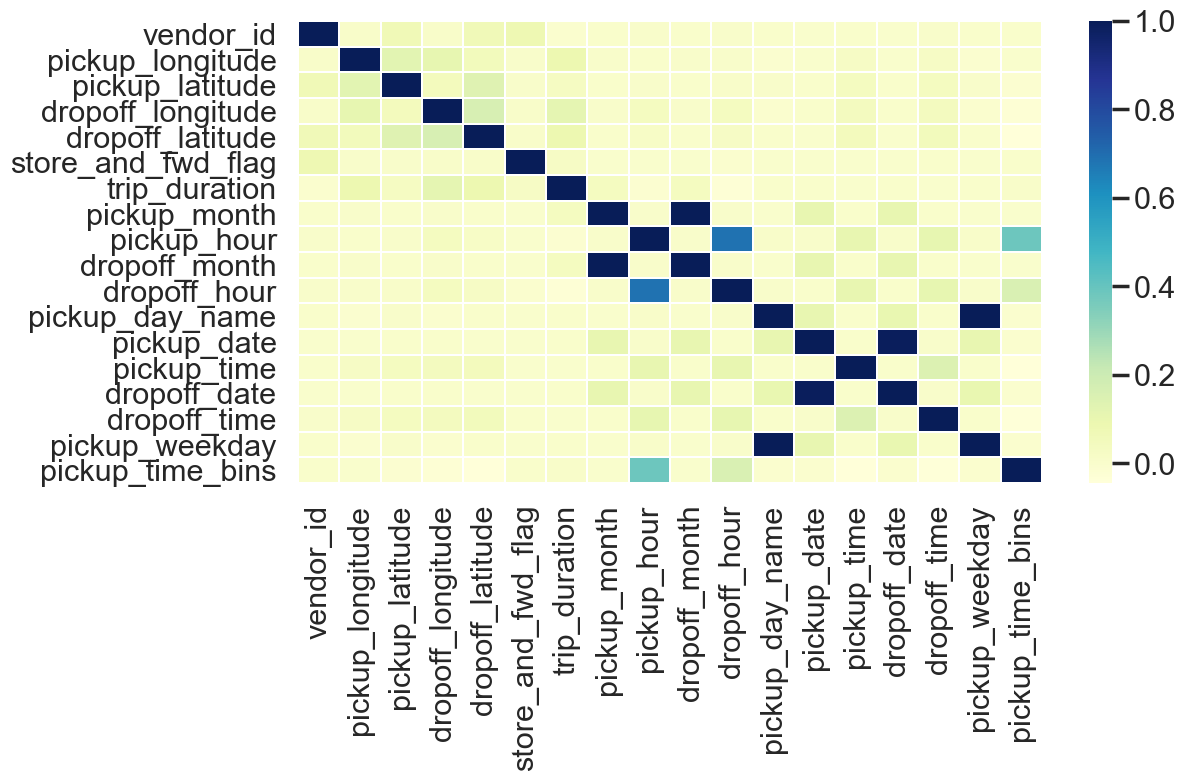

In [46]:
plt.figure(figsize=(12, 6))
df = df.drop(['id','passenger_count','log_trip_duration'],axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.



